In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

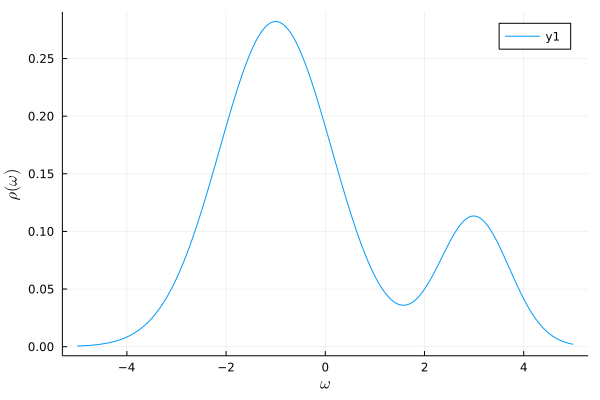

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#two peak model
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#three peak model
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

38

In [8]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [9]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [10]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 33
N_imp 33


In [11]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H_max, lambda, true)
;

Pick matrix is positive semi-definite.
H= 1
Iter     Function value   Gradient norm 
     0     2.617143e-02     1.842040e-01
 * time: 0.05645012855529785
     1     2.225416e-02     1.463159e-01
 * time: 3.2404119968414307
     2     6.115413e-03     1.746054e-01
 * time: 3.6771440505981445
     3     4.519404e-03     4.133870e-03
 * time: 4.1502602100372314
     4     4.491214e-03     6.815028e-04
 * time: 4.736479043960571
     5     4.491185e-03     1.479319e-04
 * time: 5.351351022720337
     6     4.491183e-03     3.625166e-05
 * time: 5.91025710105896
     7     4.491183e-03     7.379662e-06
 * time: 6.301764011383057
     8     4.491183e-03     1.812666e-06
 * time: 6.867322206497192
     9     4.491183e-03     3.768841e-07
 * time: 7.297969102859497
    10     4.491183e-03     8.437534e-08
 * time: 7.9366161823272705
    11     4.491183e-03     1.814694e-08
 * time: 8.373392105102539
    12     4.491183e-03     4.063740e-09
 * time: 8.740584135055542
max_theta=0.10735709249018

In [ ]:
@time Nevanlinna.solve(sol)

H= 1
Iter     Function value   Gradient norm 
     0     4.491183e-03     4.063740e-09
 * time: 0.0003628730773925781
max_theta=0.107357092490184595864705777319778058565173506290580245271190909375785649043819165438726361864919444155975234315761576856569577971419232616495861052492150375
hardy optimization was success.
H= 2
Iter     Function value   Gradient norm 
     0     4.491183e-03     5.367374e-02
 * time: 0.0003139972686767578
     1     4.358663e-03     4.840987e-02
 * time: 0.49835205078125
     2     3.976801e-03     2.831808e-02
 * time: 0.969728946685791
     3     3.060425e-03     1.153667e-02
 * time: 1.644960880279541
     4     2.381317e-03     5.427101e-02
 * time: 2.5621190071105957
     5     1.751551e-03     2.635137e-02
 * time: 3.247781991958618
     6     1.668793e-03     6.968480e-03
 * time: 3.9066598415374756
     7     1.664858e-03     1.013875e-03
 * time: 4.595460891723633
     8     1.664740e-03     3.261968e-04
 * time: 5.2312538623809814
     9     1.6647

    32     4.936087e-05     1.878512e-05
 * time: 28.648967027664185
    33     4.936085e-05     4.136604e-06
 * time: 29.2552969455719
    34     4.936085e-05     1.584267e-06
 * time: 30.221237897872925
    35     4.936085e-05     7.452359e-07
 * time: 30.792814016342163
    36     4.936085e-05     2.602491e-07
 * time: 31.39732789993286
    37     4.936085e-05     9.189213e-08
 * time: 31.970783948898315
    38     4.936085e-05     3.799211e-08
 * time: 32.64061999320984
    39     4.936085e-05     1.588797e-08
 * time: 33.51097893714905
    40     4.936085e-05     5.030449e-09
 * time: 34.027251958847046
max_theta=0.391295127414999236530927447167495956762282783320507452423203693541569599829613417092429286313378515724145279622742459737789007471619022211906029399879106011
hardy optimization was success.
H= 6
Iter     Function value   Gradient norm 
     0     4.936085e-05     3.353650e-03
 * time: 0.0004189014434814453
     1     4.892681e-05     3.068582e-03
 * time: 0.7187919616699

    52     7.586272e-06     6.242695e-04
 * time: 51.52242088317871
    53     7.558978e-06     7.758315e-04
 * time: 52.550734996795654
    54     7.511102e-06     8.201604e-04
 * time: 53.5558021068573
    55     7.431893e-06     4.727278e-04
 * time: 54.62262797355652
    56     7.403165e-06     2.585768e-04
 * time: 55.658262968063354
    57     7.398671e-06     6.088184e-05
 * time: 56.363399028778076
    58     7.398275e-06     2.627410e-05
 * time: 57.38823699951172
    59     7.398209e-06     1.388356e-05
 * time: 58.14773988723755
    60     7.398189e-06     5.501044e-06
 * time: 58.77813410758972
    61     7.398186e-06     2.402924e-06
 * time: 59.47828507423401
    62     7.398186e-06     1.234945e-06
 * time: 60.589932918548584
    63     7.398186e-06     4.832187e-07
 * time: 61.39053702354431
    64     7.398186e-06     2.109278e-07
 * time: 62.05328989028931
    65     7.398186e-06     9.572243e-08
 * time: 62.727701902389526
    66     7.398186e-06     4.550531e-08
 * 

    13     2.930541e-06     4.647020e-04
 * time: 13.770328044891357
    14     2.900217e-06     1.497529e-04
 * time: 14.55399489402771
    15     2.892527e-06     1.134025e-04
 * time: 15.750546932220459
    16     2.878521e-06     2.015430e-04
 * time: 17.444098949432373
    17     2.867763e-06     2.164219e-04
 * time: 18.64697504043579
    18     2.856963e-06     2.469100e-04
 * time: 20.1922550201416
    19     2.847665e-06     2.458355e-04
 * time: 21.63367009162903
    20     2.836273e-06     1.496867e-04
 * time: 22.848728895187378
    21     2.824718e-06     1.872099e-04
 * time: 24.067634105682373
    22     2.821677e-06     1.330664e-04
 * time: 24.901143074035645
    23     2.811238e-06     2.409195e-04
 * time: 26.23768901824951
    24     2.795905e-06     4.113640e-04
 * time: 27.472615957260132
    25     2.766656e-06     5.207140e-04
 * time: 28.677812099456787
    26     2.739181e-06     5.436794e-04
 * time: 29.87759304046631
    27     2.704411e-06     3.511445e-04


    26     1.874408e-06     1.069190e-04
 * time: 31.832782983779907
    27     1.872458e-06     1.476151e-04
 * time: 33.09468603134155
    28     1.869414e-06     2.089303e-04
 * time: 34.38051509857178
    29     1.866268e-06     2.470823e-04
 * time: 35.73479413986206
    30     1.860976e-06     2.811975e-04
 * time: 37.08028793334961
    31     1.855035e-06     2.578842e-04
 * time: 38.337584018707275
    32     1.843291e-06     1.039172e-04
 * time: 39.59570598602295
    33     1.841095e-06     9.221586e-05
 * time: 40.469330072402954
    34     1.840066e-06     2.747859e-05
 * time: 41.31517004966736
    35     1.839644e-06     3.669494e-05
 * time: 42.62063407897949
    36     1.839019e-06     7.188854e-05
 * time: 43.865036964416504
    37     1.838193e-06     9.200893e-05
 * time: 44.76119899749756
    38     1.837096e-06     1.301916e-04
 * time: 46.02951002120972
    39     1.835629e-06     1.682294e-04
 * time: 47.32833409309387
    40     1.833433e-06     2.190859e-04
 * 

    14     1.560391e-06     3.660198e-05
 * time: 15.53982400894165
    15     1.556133e-06     8.045149e-05
 * time: 17.524878978729248
    16     1.554989e-06     4.580816e-05
 * time: 18.359591007232666
    17     1.553911e-06     5.207494e-05
 * time: 19.613543033599854
    18     1.546879e-06     4.567846e-05
 * time: 21.366062879562378
    19     1.544817e-06     5.380671e-05
 * time: 22.619804859161377
    20     1.543490e-06     6.346235e-05
 * time: 24.25384783744812
    21     1.538237e-06     1.286493e-04
 * time: 26.38641095161438
    22     1.535292e-06     1.410565e-04
 * time: 27.717329025268555
    23     1.533421e-06     9.875934e-05
 * time: 29.225010871887207
    24     1.531477e-06     8.264369e-05
 * time: 30.5519380569458
    25     1.530145e-06     4.094329e-05
 * time: 31.860360860824585
    26     1.529932e-06     2.675952e-05
 * time: 32.76410794258118
    27     1.529719e-06     2.020845e-05
 * time: 34.07985305786133
    28     1.529608e-06     2.731860e-05


   134     1.428969e-06     1.378080e-05
 * time: 159.37048888206482
   135     1.428965e-06     1.539899e-05
 * time: 160.29707384109497
   136     1.428959e-06     1.842294e-05
 * time: 161.6254370212555
   137     1.428952e-06     2.056787e-05
 * time: 162.47311806678772
   138     1.428942e-06     2.450424e-05
 * time: 163.82157397270203
   139     1.428930e-06     2.734544e-05
 * time: 164.75882005691528
   140     1.428911e-06     3.244391e-05
 * time: 166.1504888534546
   141     1.428890e-06     3.620298e-05
 * time: 167.05419301986694
   142     1.428858e-06     4.274621e-05
 * time: 168.33417296409607
   143     1.428821e-06     4.770587e-05
 * time: 169.20059895515442
   144     1.428763e-06     5.596315e-05
 * time: 170.54373693466187
   145     1.428697e-06     6.245315e-05
 * time: 171.41533088684082
   146     1.428593e-06     7.250120e-05
 * time: 172.71650099754333
   147     1.428470e-06     8.074074e-05
 * time: 174.04534196853638
   148     1.428267e-06     9.163955

    83     1.389880e-06     2.685704e-05
 * time: 108.84044194221497
    84     1.389838e-06     2.814324e-05
 * time: 109.69379806518555
    85     1.389745e-06     4.396900e-05
 * time: 111.00627613067627
    86     1.389667e-06     4.497468e-05
 * time: 111.89869093894958
    87     1.389504e-06     6.586901e-05
 * time: 113.44546604156494
    88     1.389367e-06     6.776221e-05
 * time: 114.3160629272461
    89     1.389075e-06     9.444916e-05
 * time: 115.73130011558533
    90     1.388834e-06     9.699975e-05
 * time: 116.62716102600098
    91     1.388301e-06     1.303757e-04
 * time: 117.99922013282776
    92     1.387876e-06     1.331197e-04
 * time: 118.96259093284607
    93     1.386865e-06     1.699878e-04
 * time: 120.28349304199219
    94     1.386062e-06     1.717410e-04
 * time: 121.18945813179016
    95     1.383735e-06     1.855581e-04
 * time: 122.56611895561218
    96     1.380254e-06     1.492217e-04
 * time: 123.89126801490784
    97     1.377148e-06     1.24383

   203     1.356567e-06     1.581943e-08
 * time: 248.10148096084595
   204     1.356567e-06     1.015703e-08
 * time: 248.99492812156677
   205     1.356567e-06     5.917621e-09
 * time: 249.93118405342102
max_theta=0.430506432579028872139694671067267909642741302297782620663654206882816033501811518356604477802080687906594332655990052768589243761389876170795861124501227118
hardy optimization was success.
H= 13
Iter     Function value   Gradient norm 
     0     1.356567e-06     8.340361e-05
 * time: 0.0002970695495605469
     1     1.356380e-06     7.311438e-05
 * time: 0.9404330253601074
     2     1.356235e-06     5.999111e-05
 * time: 1.867138147354126
     3     1.356025e-06     3.838498e-05
 * time: 2.7689599990844727
     4     1.355799e-06     2.786451e-05
 * time: 3.6959822177886963
     5     1.355553e-06     2.383010e-05
 * time: 4.654162168502808
     6     1.355282e-06     2.802067e-05
 * time: 5.723695993423462
     7     1.354973e-06     2.531585e-05
 * time: 6.6675381660

   114     1.342937e-06     9.047461e-05
 * time: 153.17099499702454
   115     1.342740e-06     9.105346e-05
 * time: 154.14852499961853
   116     1.342120e-06     1.029862e-04
 * time: 155.65672206878662
   117     1.341226e-06     9.327354e-05
 * time: 157.12053608894348
   118     1.339740e-06     8.069946e-05
 * time: 158.70844101905823
   119     1.339289e-06     2.642977e-05
 * time: 159.77069306373596
   120     1.339185e-06     1.908636e-05
 * time: 161.2841601371765
   121     1.339159e-06     9.086663e-06
 * time: 162.25219106674194
   122     1.339139e-06     7.913097e-06
 * time: 163.72836899757385
   123     1.339134e-06     2.982740e-06
 * time: 164.7546660900116
   124     1.339131e-06     3.813596e-06
 * time: 166.41228604316711
   125     1.339129e-06     1.250659e-06
 * time: 167.50974106788635
   126     1.339127e-06     4.207274e-06
 * time: 168.98107600212097
   127     1.339126e-06     3.470622e-06
 * time: 169.96965718269348
   128     1.339121e-06     7.137981

   234     1.329446e-06     4.165523e-07
 * time: 304.4180181026459
   235     1.329446e-06     3.455452e-07
 * time: 306.05076718330383
   236     1.329446e-06     1.565241e-07
 * time: 307.12485003471375
   237     1.329446e-06     1.384513e-07
 * time: 308.76991510391235
   238     1.329446e-06     6.046247e-08
 * time: 309.8021981716156
   239     1.329446e-06     5.355178e-08
 * time: 311.3145320415497
   240     1.329446e-06     2.357929e-08
 * time: 312.4341461658478
   241     1.329446e-06     2.107004e-08
 * time: 313.93179512023926
   242     1.329446e-06     8.913023e-09
 * time: 314.91598200798035
max_theta=0.435121272960275384445972830572202786353110635258574540868016451682197089248771529738422128487564247162453143706053737284750073706310419049135600234816627917
hardy optimization was success.
H= 14
Iter     Function value   Gradient norm 
     0     1.329446e-06     5.270741e-05
 * time: 0.0003178119659423828
     1     1.329374e-06     4.597913e-05
 * time: 1.13999390602

   108     1.324431e-06     6.351987e-06
 * time: 154.98323798179626
   109     1.324428e-06     6.741673e-06
 * time: 156.2184669971466
   110     1.324424e-06     8.289545e-06
 * time: 157.34471678733826
   111     1.324421e-06     9.145284e-06
 * time: 158.32267999649048
   112     1.324417e-06     1.052690e-05
 * time: 159.94531393051147
   113     1.324412e-06     1.139116e-05
 * time: 161.5809359550476
   114     1.324406e-06     1.251155e-05
 * time: 163.18134188652039
   115     1.324398e-06     1.254202e-05
 * time: 164.776508808136
   116     1.324373e-06     9.564855e-06
 * time: 166.79293489456177
   117     1.324352e-06     1.070363e-05
 * time: 168.54794096946716
   118     1.324344e-06     2.932503e-06
 * time: 169.52499079704285
   119     1.324342e-06     2.329105e-06
 * time: 171.1039228439331
   120     1.324341e-06     1.180485e-06
 * time: 172.12399792671204
   121     1.324340e-06     1.958684e-06
 * time: 173.7400369644165
   122     1.324340e-06     9.491693e-07

   228     1.318744e-06     1.367473e-06
 * time: 316.4582848548889
   229     1.318744e-06     1.801812e-06
 * time: 318.1038680076599
   230     1.318744e-06     1.769201e-06
 * time: 319.1331298351288
   231     1.318744e-06     2.342178e-06
 * time: 320.68074679374695
   232     1.318743e-06     2.303651e-06
 * time: 321.6681818962097
   233     1.318743e-06     3.041394e-06
 * time: 323.2722477912903
   234     1.318743e-06     2.998405e-06
 * time: 324.31698083877563
   235     1.318743e-06     3.946092e-06
 * time: 325.8477590084076
   236     1.318742e-06     3.892485e-06
 * time: 326.90749287605286
   237     1.318742e-06     5.086279e-06
 * time: 328.4065418243408
   238     1.318741e-06     5.014945e-06
 * time: 329.4295828342438
   239     1.318740e-06     6.573614e-06
 * time: 330.9890308380127
   240     1.318740e-06     6.498142e-06
 * time: 331.9523239135742
   241     1.318738e-06     8.465397e-06
 * time: 333.4936900138855
   242     1.318737e-06     8.379262e-06
 * t

    72     1.316430e-06     4.584695e-06
 * time: 105.55438709259033
    73     1.316428e-06     4.166453e-06
 * time: 106.62518906593323
    74     1.316425e-06     6.183306e-06
 * time: 107.67531991004944
    75     1.316423e-06     6.030756e-06
 * time: 108.7816550731659
    76     1.316420e-06     7.855672e-06
 * time: 109.90389609336853
    77     1.316417e-06     7.988622e-06
 * time: 110.96618509292603
    78     1.316414e-06     9.810266e-06
 * time: 112.06721806526184
    79     1.316411e-06     9.978887e-06
 * time: 113.13917088508606
    80     1.316407e-06     1.178905e-05
 * time: 114.8217339515686
    81     1.316403e-06     1.203399e-05
 * time: 115.85441589355469
    82     1.316397e-06     1.393438e-05
 * time: 117.44260692596436
    83     1.316392e-06     1.424365e-05
 * time: 118.49235010147095
    84     1.316384e-06     1.589055e-05
 * time: 120.08371806144714
    85     1.316374e-06     1.598890e-05
 * time: 121.71492195129395
    86     1.316342e-06     1.433142

   192     1.315534e-06     7.838833e-07
 * time: 239.19670987129211
   193     1.315534e-06     9.634553e-07
 * time: 240.14519095420837
   194     1.315534e-06     3.099295e-07
 * time: 240.78260803222656
   195     1.315534e-06     6.075743e-07
 * time: 241.76594400405884
   196     1.315534e-06     2.563506e-07
 * time: 242.4145040512085
   197     1.315534e-06     6.636958e-07
 * time: 243.3887059688568
   198     1.315534e-06     4.767478e-07
 * time: 244.06744408607483
   199     1.315534e-06     9.884646e-07
 * time: 245.0632200241089
   200     1.315534e-06     8.146520e-07
 * time: 245.68274307250977
   201     1.315533e-06     1.352743e-06
 * time: 246.59310603141785
   202     1.315533e-06     1.146741e-06
 * time: 247.22677302360535
   203     1.315533e-06     1.874643e-06
 * time: 248.17976903915405
   204     1.315533e-06     1.722834e-06
 * time: 248.78280997276306
   205     1.315533e-06     2.617613e-06
 * time: 249.69118905067444
   206     1.315533e-06     2.468251e

    47     1.313232e-06     5.145196e-06
 * time: 41.94014000892639
    48     1.313226e-06     6.376937e-06
 * time: 42.878504037857056
    49     1.313217e-06     5.829865e-06
 * time: 43.90965390205383
    50     1.313214e-06     1.863806e-06
 * time: 44.53791809082031
    51     1.313212e-06     1.220602e-06
 * time: 45.57683300971985
    52     1.313211e-06     2.497035e-06
 * time: 46.217819929122925
    53     1.313210e-06     2.680785e-06
 * time: 47.16023588180542
    54     1.313209e-06     3.293136e-06
 * time: 47.82651901245117
    55     1.313208e-06     3.746312e-06
 * time: 48.80459499359131
    56     1.313207e-06     4.247255e-06
 * time: 49.435842990875244
    57     1.313205e-06     4.567792e-06
 * time: 50.38788294792175
    58     1.313204e-06     4.984527e-06
 * time: 51.054091930389404
    59     1.313202e-06     5.730147e-06
 * time: 52.049341917037964
    60     1.313201e-06     6.150802e-06
 * time: 52.71648287773132
    61     1.313199e-06     7.010558e-06
 *

   167     1.312845e-06     1.798989e-07
 * time: 144.61143898963928
   168     1.312845e-06     1.715293e-07
 * time: 145.32329487800598
   169     1.312845e-06     2.263031e-07
 * time: 145.9930238723755
   170     1.312845e-06     2.182413e-07
 * time: 146.66375589370728
   171     1.312845e-06     2.666372e-07
 * time: 147.338063955307
   172     1.312845e-06     2.696578e-07
 * time: 148.07493495941162
   173     1.312845e-06     3.394210e-07
 * time: 148.74019694328308
   174     1.312845e-06     3.451579e-07
 * time: 149.38146805763245
   175     1.312845e-06     4.317726e-07
 * time: 150.01004004478455
   176     1.312845e-06     4.507797e-07
 * time: 150.66111207008362
   177     1.312845e-06     5.379877e-07
 * time: 151.32719802856445
   178     1.312845e-06     5.548520e-07
 * time: 152.01601004600525
   179     1.312845e-06     6.376067e-07
 * time: 152.71414303779602
   180     1.312845e-06     6.533334e-07
 * time: 153.4122838973999
   181     1.312845e-06     7.408790e-

   287     1.312296e-06     6.489428e-07
 * time: 227.64006996154785
   288     1.312296e-06     6.650197e-07
 * time: 228.28866696357727
   289     1.312296e-06     7.904426e-07
 * time: 228.93457198143005
   290     1.312296e-06     8.142902e-07
 * time: 229.6422770023346
   291     1.312296e-06     9.453939e-07
 * time: 230.36813187599182
   292     1.312296e-06     9.774637e-07
 * time: 230.99897599220276
   293     1.312295e-06     1.112144e-06
 * time: 231.6485779285431
   294     1.312295e-06     1.152475e-06
 * time: 232.33830308914185
   295     1.312295e-06     1.292497e-06
 * time: 233.01793694496155
   296     1.312295e-06     1.340158e-06
 * time: 233.65161609649658
   297     1.312295e-06     1.488638e-06
 * time: 234.28962206840515
   298     1.312295e-06     1.542634e-06
 * time: 234.96412301063538
   299     1.312295e-06     1.701528e-06
 * time: 235.61291408538818
   300     1.312295e-06     1.761786e-06
 * time: 236.2762200832367
   301     1.312295e-06     1.931454e

   407     1.311755e-06     4.054747e-08
 * time: 310.03663897514343
   408     1.311755e-06     4.358454e-08
 * time: 310.7144730091095
   409     1.311755e-06     4.804228e-08
 * time: 311.3945679664612
   410     1.311755e-06     5.141894e-08
 * time: 312.0563499927521
   411     1.311755e-06     5.613233e-08
 * time: 312.76708602905273
   412     1.311755e-06     5.975836e-08
 * time: 313.4279110431671
   413     1.311755e-06     6.480783e-08
 * time: 314.0762388706207
   414     1.311755e-06     6.867905e-08
 * time: 314.7357540130615
   415     1.311755e-06     7.411986e-08
 * time: 315.39940905570984
   416     1.311755e-06     7.829799e-08
 * time: 316.0453870296478
   417     1.311755e-06     8.413415e-08
 * time: 316.70943903923035
   418     1.311755e-06     8.867454e-08
 * time: 317.36048197746277
   419     1.311755e-06     9.489949e-08
 * time: 318.0312919616699
   420     1.311755e-06     9.981893e-08
 * time: 318.7104170322418
   421     1.311755e-06     1.064560e-07
 *

   527     1.311752e-06     6.925593e-06
 * time: 390.2628870010376
   528     1.311752e-06     7.128408e-06
 * time: 390.9199540615082
   529     1.311751e-06     7.438679e-06
 * time: 391.5745620727539
   530     1.311751e-06     7.654936e-06
 * time: 392.20917201042175
   531     1.311751e-06     7.990543e-06
 * time: 392.8650619983673
   532     1.311750e-06     8.221046e-06
 * time: 393.535306930542
   533     1.311750e-06     8.584376e-06
 * time: 394.162122964859
   534     1.311750e-06     8.829962e-06
 * time: 394.8335609436035
   535     1.311749e-06     9.223696e-06
 * time: 395.471088886261
   536     1.311749e-06     9.485236e-06
 * time: 396.1597020626068
   537     1.311748e-06     9.912400e-06
 * time: 396.8364140987396
   538     1.311748e-06     1.019080e-05
 * time: 397.50944900512695
   539     1.311747e-06     1.065483e-05
 * time: 398.18011498451233
   540     1.311747e-06     1.095102e-05
 * time: 398.8516869544983
   541     1.311746e-06     1.145586e-05
 * time

    55     1.311073e-06     2.117988e-06
 * time: 50.10905194282532
    56     1.311072e-06     3.099695e-06
 * time: 51.100988149642944
    57     1.311070e-06     2.848367e-06
 * time: 52.06426215171814
    58     1.311069e-06     3.001689e-06
 * time: 53.02312111854553
    59     1.311066e-06     3.355660e-06
 * time: 54.00226712226868
    60     1.311065e-06     1.824496e-06
 * time: 54.63300800323486
    61     1.311064e-06     1.542578e-06
 * time: 55.602977991104126
    62     1.311064e-06     8.027113e-07
 * time: 56.26402401924133
    63     1.311063e-06     2.314825e-06
 * time: 57.28320503234863
    64     1.311063e-06     1.376327e-06
 * time: 57.91441798210144
    65     1.311062e-06     2.319593e-06
 * time: 58.912572145462036
    66     1.311062e-06     1.733305e-06
 * time: 59.63677906990051
    67     1.311062e-06     2.823175e-06
 * time: 60.601675033569336
    68     1.311061e-06     2.294238e-06
 * time: 61.292004108428955
    69     1.311061e-06     3.302904e-06
 *

   176     1.310878e-06     1.206951e-07
 * time: 719.3641850948334
   177     1.310878e-06     2.118539e-07
 * time: 720.0412430763245
   178     1.310878e-06     8.869490e-08
 * time: 720.7473649978638
   179     1.310878e-06     2.120561e-07
 * time: 721.3163421154022
   180     1.310878e-06     1.191485e-07
 * time: 721.9098770618439
   181     1.310878e-06     2.300773e-07
 * time: 722.4777750968933
   182     1.310878e-06     1.698278e-07
 * time: 723.0687570571899
   183     1.310878e-06     2.769576e-07
 * time: 723.6939060688019
   184     1.310878e-06     2.313620e-07
 * time: 724.2671840190887
   185     1.310878e-06     3.315991e-07
 * time: 724.8451881408691
   186     1.310878e-06     2.964572e-07
 * time: 725.4223821163177
   187     1.310878e-06     3.903448e-07
 * time: 726.0011100769043
   188     1.310878e-06     3.662383e-07
 * time: 726.5562601089478
   189     1.310878e-06     4.585218e-07
 * time: 727.1528630256653
   190     1.310878e-06     4.405466e-07
 * time

   297     1.310752e-06     1.665633e-07
 * time: 853.1523909568787
   298     1.310752e-06     6.767174e-08
 * time: 854.225744009018
   299     1.310752e-06     1.371577e-07
 * time: 855.8474040031433
   300     1.310752e-06     6.748591e-08
 * time: 856.9546711444855
   301     1.310752e-06     1.443385e-07
 * time: 858.6394419670105
   302     1.310752e-06     8.457189e-08
 * time: 859.7289400100708
   303     1.310752e-06     1.661072e-07
 * time: 861.3370881080627
   304     1.310752e-06     1.251055e-07
 * time: 862.399199962616
   305     1.310752e-06     2.079149e-07
 * time: 864.0130980014801
   306     1.310752e-06     1.741709e-07
 * time: 865.1035540103912
   307     1.310752e-06     2.565245e-07
 * time: 866.768424987793
   308     1.310752e-06     2.297692e-07
 * time: 867.8082201480865
   309     1.310752e-06     3.111753e-07
 * time: 869.4881091117859
   310     1.310752e-06     2.862575e-07
 * time: 870.5571341514587
   311     1.310752e-06     3.656403e-07
 * time: 8

     0     1.310358e-06     7.650303e-06
 * time: 0.00025200843811035156
     1     1.310357e-06     6.925802e-06
 * time: 0.7625010013580322
     2     1.310356e-06     5.604817e-06
 * time: 1.4285261631011963
     3     1.310354e-06     4.380445e-06
 * time: 2.123922109603882
     4     1.310352e-06     3.188575e-06
 * time: 2.806856155395508
     5     1.310350e-06     2.663283e-06
 * time: 3.478527069091797
     6     1.310348e-06     2.870807e-06
 * time: 4.207653999328613
     7     1.310346e-06     2.670987e-06
 * time: 4.859041213989258
     8     1.310343e-06     2.890824e-06
 * time: 5.521614074707031
     9     1.310340e-06     2.376753e-06
 * time: 6.2464540004730225
    10     1.310336e-06     1.586497e-06
 * time: 6.917013168334961
    11     1.310332e-06     1.950219e-06
 * time: 7.570301055908203
    12     1.310326e-06     2.277241e-06
 * time: 8.255503177642822
    13     1.310321e-06     1.723403e-06
 * time: 8.977634191513062
    14     1.310312e-06     1.373775e-06

   120     1.309875e-06     3.646949e-06
 * time: 167.87152004241943
   121     1.309874e-06     1.889040e-06
 * time: 168.994775056839
   122     1.309874e-06     3.643189e-06
 * time: 170.74669814109802
   123     1.309873e-06     1.449235e-06
 * time: 171.88910222053528
   124     1.309872e-06     3.858025e-06
 * time: 173.58256101608276
   125     1.309872e-06     1.079236e-06
 * time: 174.73338222503662
   126     1.309871e-06     4.225688e-06
 * time: 176.4787940979004
   127     1.309870e-06     1.260455e-06
 * time: 177.64116501808167
   128     1.309869e-06     4.662936e-06
 * time: 179.36711502075195
   129     1.309868e-06     1.919474e-06
 * time: 180.46801900863647
   130     1.309866e-06     4.859223e-06
 * time: 182.20484399795532
   131     1.309865e-06     2.591189e-06
 * time: 183.51860308647156
   132     1.309863e-06     4.905606e-06
 * time: 185.35430121421814
   133     1.309863e-06     3.397444e-06
 * time: 186.5298080444336
   134     1.309861e-06     4.331431e-

   240     1.309727e-06     8.039633e-06
 * time: 348.08283710479736
   241     1.309725e-06     9.108425e-06
 * time: 349.77326107025146
   242     1.309723e-06     8.944575e-06
 * time: 350.9355230331421
   243     1.309720e-06     1.021881e-05
 * time: 352.6071321964264
   244     1.309718e-06     1.016471e-05
 * time: 353.77999114990234
   245     1.309713e-06     1.051025e-05
 * time: 355.3837490081787
   246     1.309710e-06     1.077570e-05
 * time: 356.5448319911957
   247     1.309702e-06     1.082935e-05
 * time: 358.3170840740204
   248     1.309686e-06     1.027019e-05
 * time: 360.0455400943756
   249     1.309664e-06     1.314425e-05
 * time: 361.7612051963806
   250     1.309649e-06     6.421185e-06
 * time: 362.90704011917114
   251     1.309640e-06     6.725426e-06
 * time: 364.5055651664734
   252     1.309636e-06     3.395187e-06
 * time: 365.6443040370941
   253     1.309633e-06     4.872039e-06
 * time: 367.2773551940918
   254     1.309632e-06     2.367331e-06
 * 

   360     1.309370e-06     1.049801e-07
 * time: 513.5531561374664
   361     1.309370e-06     1.341455e-07
 * time: 515.2146542072296
   362     1.309370e-06     1.250036e-07
 * time: 516.3744220733643
   363     1.309370e-06     1.537603e-07
 * time: 518.0926430225372
   364     1.309370e-06     1.443657e-07
 * time: 519.2680790424347
   365     1.309370e-06     1.743457e-07
 * time: 520.9111750125885
   366     1.309370e-06     1.666619e-07
 * time: 522.027321100235
   367     1.309370e-06     1.977026e-07
 * time: 523.1374452114105
   368     1.309370e-06     1.906982e-07
 * time: 524.3062810897827
   369     1.309370e-06     2.239598e-07
 * time: 525.4224350452423
   370     1.309370e-06     2.182911e-07
 * time: 526.543240070343
   371     1.309370e-06     2.520701e-07
 * time: 527.6560451984406
   372     1.309370e-06     2.466979e-07
 * time: 528.7878351211548
   373     1.309370e-06     2.809455e-07
 * time: 529.9090461730957
   374     1.309370e-06     2.750868e-07
 * time: 

   481     1.309357e-06     1.173251e-05
 * time: 635.8620409965515
   482     1.309356e-06     1.180924e-05
 * time: 636.5444099903107
   483     1.309355e-06     1.243427e-05
 * time: 637.5554211139679
   484     1.309354e-06     1.252006e-05
 * time: 638.2232010364532
   485     1.309353e-06     1.317622e-05
 * time: 639.3638641834259
   486     1.309352e-06     1.327210e-05
 * time: 640.0765450000763
   487     1.309350e-06     1.396068e-05
 * time: 641.146781206131
   488     1.309349e-06     1.406776e-05
 * time: 641.9024751186371
   489     1.309348e-06     1.479008e-05
 * time: 643.0076470375061
   490     1.309347e-06     1.490960e-05
 * time: 643.6797051429749
   491     1.309345e-06     1.566704e-05
 * time: 644.7100300788879
   492     1.309343e-06     1.580036e-05
 * time: 645.394073009491
   493     1.309342e-06     1.659432e-05
 * time: 646.3862411975861
   494     1.309340e-06     1.674295e-05
 * time: 647.0834341049194
   495     1.309338e-06     1.757480e-05
 * time: 

    48     1.308755e-06     6.235969e-07
 * time: 45.80317997932434
    49     1.308755e-06     9.585905e-07
 * time: 46.53928303718567
    50     1.308755e-06     5.196403e-07
 * time: 47.620646953582764
    51     1.308755e-06     4.944271e-07
 * time: 48.684776067733765
    52     1.308754e-06     1.361235e-06
 * time: 49.77451300621033
    53     1.308754e-06     4.132893e-07
 * time: 50.489701986312866
    54     1.308754e-06     1.218937e-06
 * time: 51.26995396614075
    55     1.308754e-06     1.151450e-07
 * time: 51.963348150253296
    56     1.308754e-06     1.107697e-06
 * time: 52.67326903343201
    57     1.308754e-06     1.705970e-07
 * time: 53.38653516769409
    58     1.308754e-06     1.051967e-06
 * time: 54.119434118270874
    59     1.308754e-06     3.249524e-07
 * time: 54.85671305656433
    60     1.308754e-06     1.035877e-06
 * time: 55.565515995025635
    61     1.308754e-06     4.656156e-07
 * time: 56.29096508026123
    62     1.308753e-06     1.041256e-06
 

   168     1.308741e-06     5.084357e-07
 * time: 150.18490409851074
   169     1.308741e-06     2.671025e-07
 * time: 150.9217550754547
   170     1.308741e-06     3.377285e-07
 * time: 151.602774143219
   171     1.308740e-06     2.010908e-07
 * time: 152.37375617027283
   172     1.308740e-06     3.043154e-07
 * time: 153.04004001617432
   173     1.308740e-06     1.501635e-07
 * time: 153.7657961845398
   174     1.308740e-06     2.961508e-07
 * time: 154.4946231842041
   175     1.308740e-06     1.173597e-07
 * time: 155.19330716133118
   176     1.308740e-06     2.807995e-07
 * time: 155.98607301712036
   177     1.308740e-06     1.258833e-07
 * time: 156.6476321220398
   178     1.308740e-06     2.922972e-07
 * time: 157.37652206420898
   179     1.308740e-06     1.690545e-07
 * time: 158.05492901802063
   180     1.308740e-06     3.179620e-07
 * time: 158.78953409194946
   181     1.308740e-06     2.162992e-07
 * time: 159.5154631137848
   182     1.308740e-06     3.467645e-07


   288     1.308737e-06     8.286137e-07
 * time: 247.75178694725037
   289     1.308737e-06     8.355967e-07
 * time: 248.99797797203064
   290     1.308737e-06     8.962380e-07
 * time: 249.8159749507904
   291     1.308737e-06     9.104152e-07
 * time: 251.10127806663513
   292     1.308737e-06     9.666176e-07
 * time: 251.87046599388123
   293     1.308737e-06     9.884354e-07
 * time: 252.99365901947021
   294     1.308737e-06     1.040552e-06
 * time: 253.70914506912231
   295     1.308737e-06     1.069922e-06
 * time: 254.77960896492004
   296     1.308737e-06     1.117980e-06
 * time: 255.5457570552826
   297     1.308737e-06     1.154606e-06
 * time: 256.7394621372223
   298     1.308737e-06     1.198498e-06
 * time: 257.44699001312256
   299     1.308737e-06     1.242570e-06
 * time: 258.52036213874817
   300     1.308737e-06     1.282364e-06
 * time: 259.2775299549103
   301     1.308737e-06     1.333993e-06
 * time: 260.36676001548767
   302     1.308737e-06     1.369724e-

   408     1.308724e-06     4.497162e-08
 * time: 356.96181416511536
   409     1.308724e-06     6.765937e-08
 * time: 358.0158221721649
   410     1.308724e-06     5.477431e-08
 * time: 358.7303020954132
   411     1.308724e-06     7.703516e-08
 * time: 359.8348879814148
   412     1.308724e-06     6.458617e-08
 * time: 360.55206203460693
   413     1.308724e-06     8.722377e-08
 * time: 361.57299995422363
   414     1.308724e-06     7.648010e-08
 * time: 362.26907300949097
   415     1.308724e-06     9.964512e-08
 * time: 363.3953649997711
   416     1.308724e-06     9.075493e-08
 * time: 364.1312201023102
   417     1.308724e-06     1.146195e-07
 * time: 365.2033131122589
   418     1.308724e-06     1.049550e-07
 * time: 365.92734718322754
   419     1.308724e-06     1.301279e-07
 * time: 366.98509097099304
   420     1.308724e-06     1.193539e-07
 * time: 367.6847081184387
   421     1.308724e-06     1.455384e-07
 * time: 368.844220161438
   422     1.308724e-06     1.349008e-07
 *

   528     1.308702e-06     3.396386e-08
 * time: 466.89569997787476
   529     1.308702e-06     2.310165e-08
 * time: 467.6225471496582
   530     1.308702e-06     2.410379e-08
 * time: 468.32496905326843
   531     1.308702e-06     1.532626e-08
 * time: 469.0326030254364
   532     1.308702e-06     1.838338e-08
 * time: 469.73976397514343
   533     1.308702e-06     1.069997e-08
 * time: 470.45636796951294
   534     1.308702e-06     1.502626e-08
 * time: 471.1874990463257
   535     1.308702e-06     7.959053e-09
 * time: 471.91688108444214
max_theta=0.469363693813360056941771737381221334305965999791977303244989984264106673211193551188099773192932850943558406241114397833782360775891811403151147123741634492
hardy optimization was success.
H= 20
Iter     Function value   Gradient norm 
     0     1.308702e-06     4.738453e-06
 * time: 0.0002579689025878906
     1     1.308699e-06     6.724252e-06
 * time: 0.7611029148101807
     2     1.308696e-06     5.731618e-06
 * time: 1.5058979988

   108     1.306795e-06     4.679979e-06
 * time: 1812.95068693161
   109     1.306795e-06     2.588474e-06
 * time: 1813.6532039642334
   110     1.306794e-06     4.687282e-06
 * time: 1814.7142479419708
   111     1.306793e-06     2.633247e-06
 * time: 1815.415897846222
   112     1.306792e-06     4.771653e-06
 * time: 1816.470293045044
   113     1.306792e-06     2.738065e-06
 * time: 1817.1977188587189
   114     1.306791e-06     4.688505e-06
 * time: 1818.2530689239502
   115     1.306790e-06     2.827729e-06
 * time: 1818.938549041748
   116     1.306789e-06     5.176672e-06
 * time: 1820.0438058376312
   117     1.306789e-06     3.696993e-06
 * time: 1820.7477729320526
   118     1.306787e-06     4.791546e-06
 * time: 1821.8246240615845
   119     1.306787e-06     3.270450e-06
 * time: 1822.5676620006561
   120     1.306785e-06     5.702387e-06
 * time: 1823.6362879276276
   121     1.306783e-06     4.454130e-06
 * time: 1824.343966960907
   122     1.306780e-06     4.100534e-06

   228     1.306691e-06     1.143468e-06
 * time: 1990.5439889431
   229     1.306691e-06     1.759309e-06
 * time: 1992.3121559619904
   230     1.306691e-06     1.291388e-06
 * time: 1993.9163129329681
   231     1.306691e-06     1.865871e-06
 * time: 1995.3714220523834
   232     1.306691e-06     1.435110e-06
 * time: 1998.3017709255219
   233     1.306691e-06     1.977784e-06
 * time: 1999.764387845993
   234     1.306691e-06     1.580577e-06
 * time: 2001.3761429786682
   235     1.306690e-06     2.097856e-06
 * time: 2002.9825229644775
   236     1.306690e-06     1.730822e-06
 * time: 2004.380737066269
   237     1.306690e-06     2.225982e-06
 * time: 2005.798919916153
   238     1.306690e-06     1.884071e-06
 * time: 2007.2591948509216
   239     1.306690e-06     2.359968e-06
 * time: 2008.7305748462677
   240     1.306690e-06     2.037280e-06
 * time: 2010.1364250183105
   241     1.306690e-06     2.495645e-06
 * time: 2011.871708869934
   242     1.306690e-06     2.189194e-06


   348     1.306647e-06     2.034678e-06
 * time: 2154.0041019916534
   349     1.306647e-06     2.159733e-06
 * time: 2155.006191968918
   350     1.306647e-06     2.134092e-06
 * time: 2156.061203956604
   351     1.306647e-06     2.260187e-06
 * time: 2157.088264942169
   352     1.306647e-06     2.235754e-06
 * time: 2158.1589908599854
   353     1.306647e-06     2.362474e-06
 * time: 2159.172693014145
   354     1.306647e-06     2.339622e-06
 * time: 2160.226150035858
   355     1.306647e-06     2.466317e-06
 * time: 2161.296073913574
   356     1.306647e-06     2.445419e-06
 * time: 2162.6761560440063
   357     1.306647e-06     2.571742e-06
 * time: 2163.9902708530426
   358     1.306647e-06     2.553011e-06
 * time: 2165.0752470493317
   359     1.306647e-06     2.678890e-06
 * time: 2166.129312992096
   360     1.306647e-06     2.662444e-06
 * time: 2167.1485528945923
   361     1.306647e-06     2.787725e-06
 * time: 2168.204108953476
   362     1.306647e-06     2.773750e-06
 

   468     1.306597e-06     2.174758e-06
 * time: 2302.425698041916
   469     1.306597e-06     2.394290e-06
 * time: 2303.9685459136963
   470     1.306597e-06     2.312105e-06
 * time: 2304.9991528987885
   471     1.306597e-06     2.539121e-06
 * time: 2307.218339920044
   472     1.306597e-06     2.455715e-06
 * time: 2309.1738889217377
   473     1.306597e-06     2.690637e-06
 * time: 2310.924393892288
   474     1.306597e-06     2.605437e-06
 * time: 2312.0031888484955
   475     1.306597e-06     2.849565e-06
 * time: 2313.516042947769
   476     1.306597e-06     2.762200e-06
 * time: 2314.539710998535
   477     1.306596e-06     3.016873e-06
 * time: 2316.2012598514557
   478     1.306596e-06     2.926955e-06
 * time: 2317.2443718910217
   479     1.306596e-06     3.192591e-06
 * time: 2318.800134897232
   480     1.306596e-06     3.099720e-06
 * time: 2319.809813976288
   481     1.306596e-06     3.376608e-06
 * time: 2321.42586684227
   482     1.306596e-06     3.280309e-06
 *

   588     1.306478e-06     1.930866e-07
 * time: 2448.827358007431
   589     1.306478e-06     2.184785e-07
 * time: 2449.80841088295
   590     1.306478e-06     2.113481e-07
 * time: 2450.855265855789
   591     1.306478e-06     2.366230e-07
 * time: 2451.917233943939
   592     1.306478e-06     2.299714e-07
 * time: 2452.9555048942566
   593     1.306478e-06     2.553412e-07
 * time: 2453.9574279785156
   594     1.306478e-06     2.489426e-07
 * time: 2455.019157886505
   595     1.306478e-06     2.744787e-07
 * time: 2456.0596499443054
   596     1.306478e-06     2.683523e-07
 * time: 2457.128562927246
   597     1.306478e-06     2.941911e-07
 * time: 2458.1927008628845
   598     1.306478e-06     2.883661e-07
 * time: 2459.208158016205
   599     1.306478e-06     3.146035e-07
 * time: 2460.3127250671387
   600     1.306478e-06     3.090767e-07
 * time: 2461.644212961197
   601     1.306478e-06     3.356485e-07
 * time: 2462.7806479930878
   602     1.306478e-06     3.304340e-07
 *

   708     1.306477e-06     2.594329e-06
 * time: 2578.3220160007477
   709     1.306477e-06     2.663119e-06
 * time: 2579.3778159618378
   710     1.306477e-06     2.669018e-06
 * time: 2580.403053998947
   711     1.306477e-06     2.739200e-06
 * time: 2581.6561930179596
   712     1.306477e-06     2.745401e-06
 * time: 2582.716600894928
   713     1.306477e-06     2.817005e-06
 * time: 2583.8073229789734
   714     1.306477e-06     2.823516e-06
 * time: 2584.7938458919525
   715     1.306477e-06     2.896571e-06
 * time: 2585.858715057373
   716     1.306477e-06     2.903399e-06
 * time: 2586.859214067459
   717     1.306476e-06     2.977932e-06
 * time: 2587.9900279045105
   718     1.306476e-06     2.985085e-06
 * time: 2589.0816600322723
   719     1.306476e-06     3.061122e-06
 * time: 2590.1387388706207
   720     1.306476e-06     3.068607e-06
 * time: 2591.222571849823
   721     1.306476e-06     3.146176e-06
 * time: 2592.317229986191
   722     1.306476e-06     3.154001e-06

In [ ]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

In [ ]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))
#plot!(omegas, rho.(omegas))

In [ ]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [ ]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [ ]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#